## Load useful libraries

In [1]:
import librosa
import matplotlib.pyplot as plt

In [2]:
from music_production_and_performance.features.key_detection import compute_chromagram
from music_production_and_performance.features.key_detection import display_chromagram
from music_production_and_performance.features.key_detection import detect_key_using_chromagram

## User settings

In [3]:
#track_to_analyze = '/home/emily/Downloads/Lady Napalm - Voice in the Distance.aiff'
track_to_analyze = '/home/emily/Downloads/Lady Napalm - Kwiky Bridge (Instant Satisfaction Mix).aiff'

sampling_rate_for_import = 48000
hop_length = 1024

## Set or compute track title

In [4]:
track_title = ''.join(track_to_analyze.split('/')[-1].split('.')[0:-1])
print(track_title)

Lady Napalm - Kwiky Bridge (Instant Satisfaction Mix)


## Do the hop length and sampling rate make sense together?

hop_length / sampling rate be roughly 21 to 23 ms

In [5]:
hop_length / sampling_rate_for_import

0.021333333333333333

## Load an audio file

In [6]:
y, sr = librosa.load(track_to_analyze, sr = 48000)  # we are using a single mono channel here for these analyses
print(sr)
print()
print(y[:10])

48000

[ 3.4993213e-06 -3.7382324e-06 -5.5802542e-05 -4.1003822e-04
 -1.2134747e-03 -2.0904215e-03 -1.6861029e-03  3.0167948e-03
  1.5007788e-02  2.8674539e-02]


## Separate harmonics and percussives into two waveforms

In [7]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

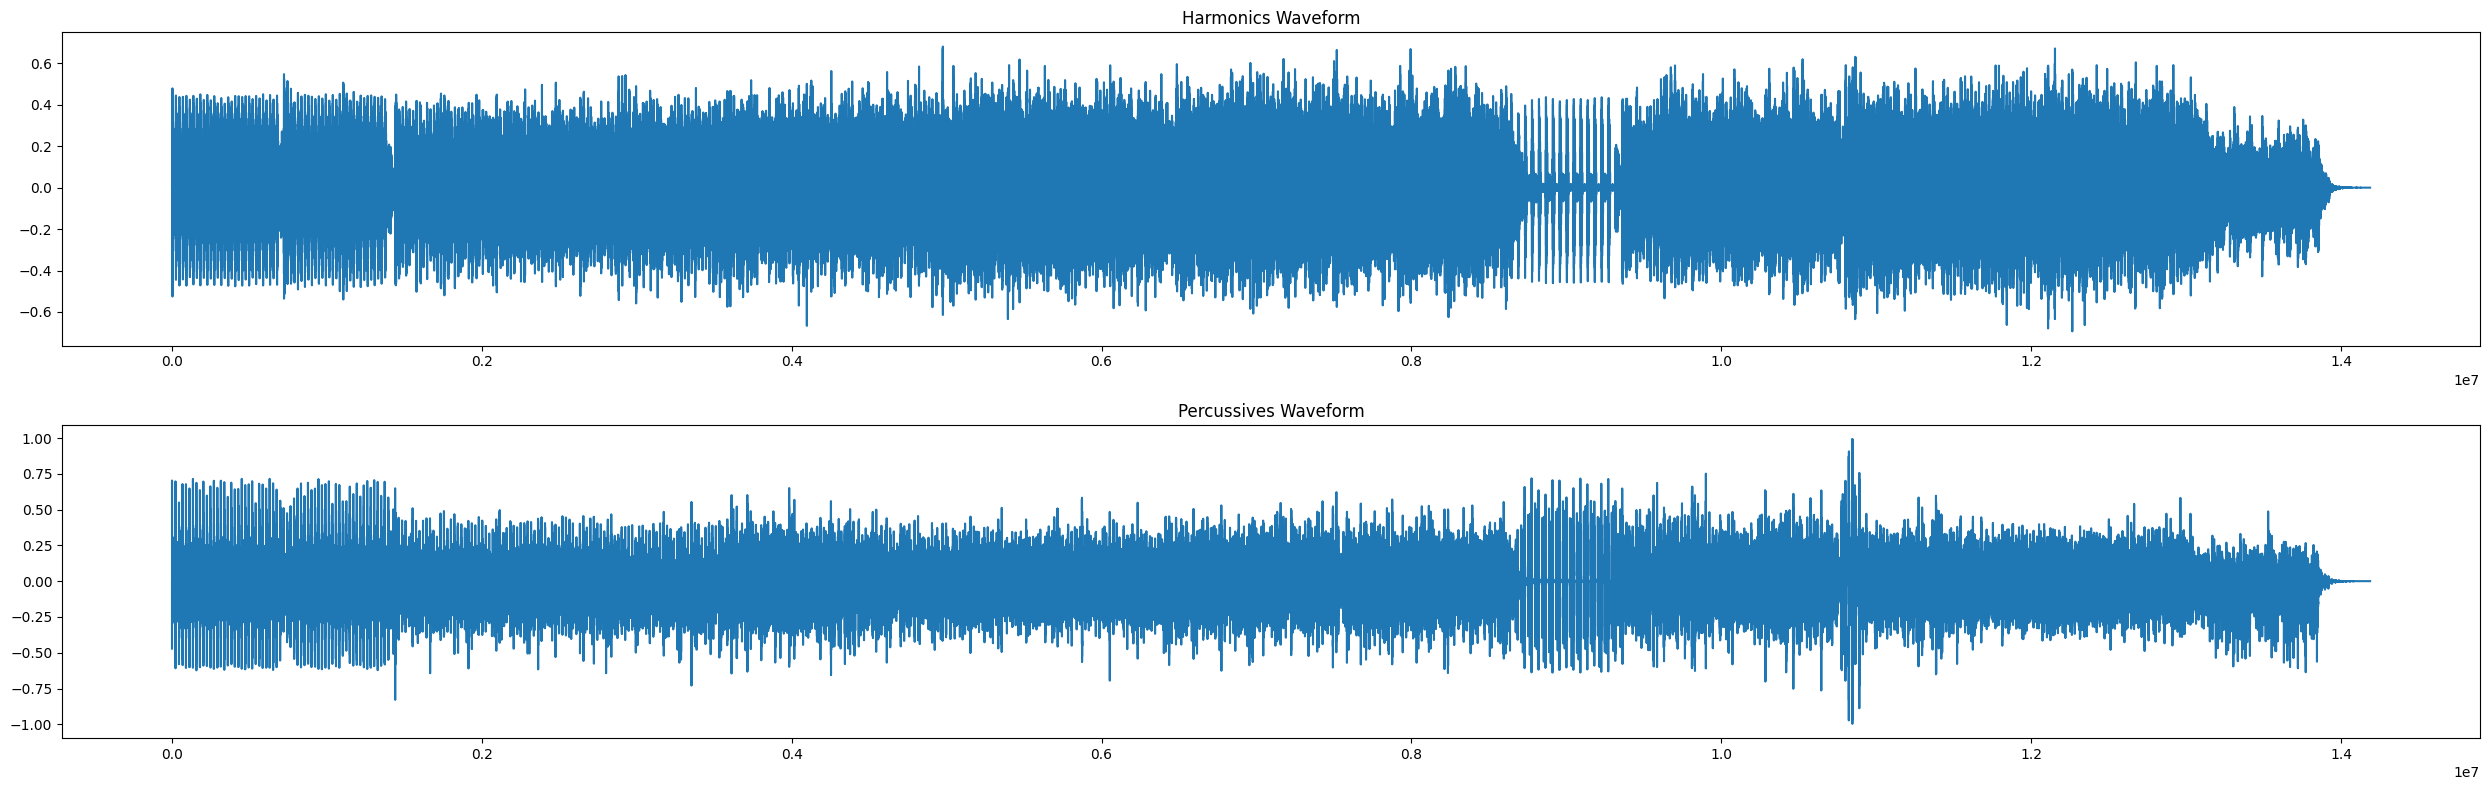

In [8]:
plt.figure(figsize = [25, 8])

plt.subplot(2, 1, 1)
plt.plot(y_harmonic)
plt.title('Harmonics Waveform')
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.plot(y_percussive)
plt.title('Percussives Waveform')
plt.tight_layout()

plt.show()
plt.close()

## Compute and display chromagram

In [9]:
chromagram_stft = compute_chromagram(y_harmonic, sr, hop_length)
chromagram_cqt = compute_chromagram(y_harmonic, sr, hop_length, function_to_use = librosa.feature.chroma_cqt)

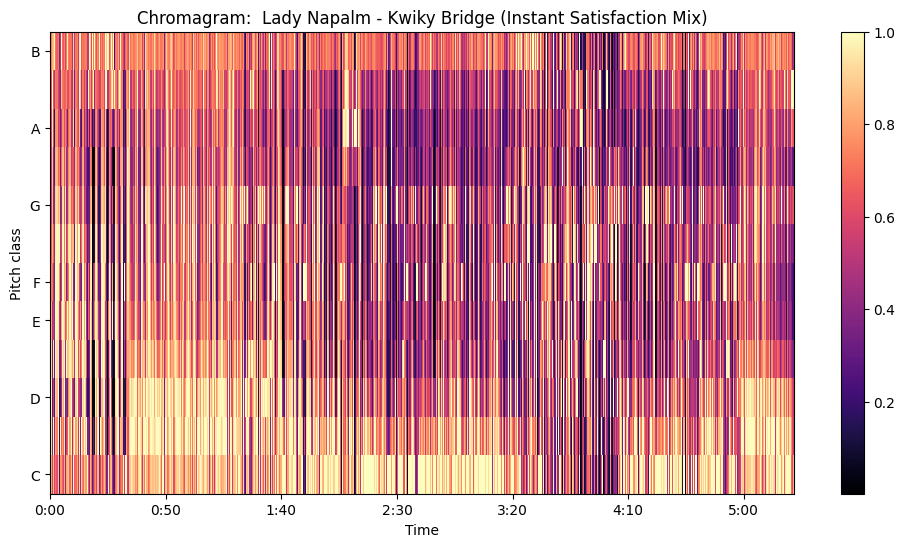

In [10]:
display_chromagram(chromagram_stft, track_title)

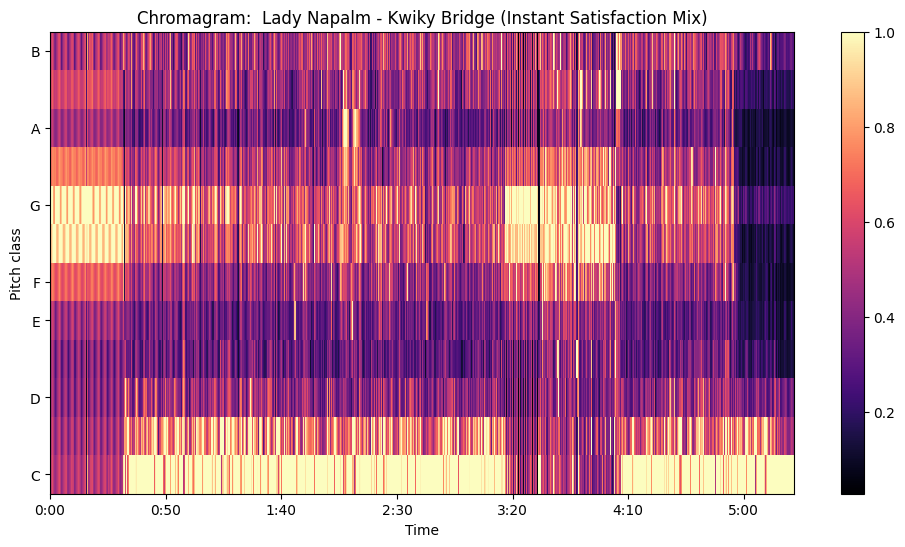

In [11]:
display_chromagram(chromagram_cqt, track_title)

## Estimate the key
Pitch class only, not scale(s) yet:

In [12]:
estimated_key_stft, estimated_key_index_stft = detect_key_using_chromagram(chromagram_stft)
estimated_key_cqt, estimated_key_index_cqt = detect_key_using_chromagram(chromagram_cqt)

print("Detected Key:", estimated_key_stft)
print("Detected Key:", estimated_key_cqt)

Detected Key: C
Detected Key: C


In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pprint as pp

from music_production_and_performance.theory.western.scales.chromatic import chromatic_scale_pitch_class_names

class Track():
    def __init__(
        self,
        track_to_analyze_filename : str,
        track_title : str,
        sampling_rate_for_import : int = 48000,
        hop_length : int = 1024
    ):
        self.track_to_analyze_filename = track_to_analyze_filename
        self.track_title = track_title
        self.sampling_rate_for_import = sampling_rate_for_import
        self.hop_length = hop_length

    def load_track_timeseries(self):
        #
        # we are using a single mono channel here for these analyses
        #
        self.y, self.sr = librosa.load(
            self.track_to_analyze_filename,
            sr = self.sampling_rate_for_import,
        )  
        print(self.sr)
        print()
        print(self.y[:10])

    def separate_harmonics_and_percussives(self):
        self.y_harmonic, self.y_percussive = librosa.effects.hpss(self.y)

    def plot_split_harmonics_and_percussives(self):
        plt.figure(figsize = [25, 8])

        plt.subplot(2, 1, 1)
        plt.plot(self.y_harmonic)
        plt.title('Harmonics Waveform')
        plt.tight_layout()

        plt.subplot(2, 1, 2)
        plt.plot(self.y_percussive)
        plt.title('Percussives Waveform')
        plt.tight_layout()

        plt.show()
        plt.close()

    # Normalized energy for each chroma bin at each frame.
    # https://librosa.org/doc/main/generated/librosa.feature.chroma_stft.html
    #
    # Energy distribution of each pitch class across time:
    # 
    def compute_chromagrams(self):
        self.chromagram_stft = librosa.feature.chroma_stft(
            y = self.y_harmonic,
            sr = self.sampling_rate_for_import,
            hop_length = self.hop_length,
        ) 
        self.chromagram_cqt = librosa.feature.chroma_cqt(
            y = self.y_harmonic,
            sr = self.sampling_rate_for_import,
            hop_length = self.hop_length,
        ) 

    # Energy distribution of each pitch class across time
    def display_chromagrams(self):
        fig, ax = plt.subplots(sharex=True, sharey=True, figsize = [12, 6])
        img = librosa.display.specshow(self.chromagram_stft, y_axis = 'chroma', x_axis = 'time', ax = ax)
        ax.set(title='Chromagram: "' + self.track_title + '", Method: "Short-Time Fourier Transform"')
        fig.colorbar(img, ax=ax)
        plt.tight_layout()
        plt.show()
        plt.close()

        fig, ax = plt.subplots(sharex=True, sharey=True, figsize = [12, 6])
        img = librosa.display.specshow(self.chromagram_cqt, y_axis = 'chroma', x_axis = 'time', ax = ax)
        ax.set(title='Chromagram: "' + self.track_title + '", Method: "Constant-Q Transform"')
        fig.colorbar(img, ax=ax)
        plt.tight_layout()
        plt.show()
        plt.close()

    def plot_chromagram_boxplot(self):
        chromagram_method_list = [self.chromagram_stft, self.chromagram_cqt]
        chromagram_method_name_list = ['Short-Time Fourier Transform', 'Constant-Q Transform']

        for chrm, method in zip(chromagram_method_list, chromagram_method_name_list):
            per_note_chromagram_values_list = []
            for note_index in np.arange(0, chrm.shape[0]):
                per_note_chromagram_values_list.append(chrm[note_index, :])
    
            plt.figure()
            plt.boxplot(per_note_chromagram_values_list, widths=0.85)
            plt.xticks(np.arange(1, len(chromatic_scale_pitch_class_names) + 1), chromatic_scale_pitch_class_names)
            plt.title('Energy Distribution of Each Pitch Class Across Time\nMethod = ' + method)
            plt.tight_layout()
            plt.show()
            plt.close()

    def estimate_key(self):
        chromagram_method_list = [self.chromagram_stft, self.chromagram_cqt]
        chromagram_method_name_list = ['Short-Time Fourier Transform', 'Constant-Q Transform']
        self.key_estimate = {'Method' : {}}
        for chrm, method in zip(chromagram_method_list, chromagram_method_name_list):
            self.key_estimate['Method'][method] = chromatic_scale_pitch_class_names[np.argmax(np.mean(chrm, axis = 1))]

    def display_key_estimates(self):
        pp.pprint(self.key_estimate) 

In [ ]:
#track_to_analyze = '/home/emily/Downloads/Lady Napalm - Voice in the Distance.aiff'
track_to_analyze = '/home/emily/Downloads/Lady Napalm - Kwiky Bridge (Instant Satisfaction Mix).aiff'

#t = Track(track_to_analyze, 'Voice in the Distance')
t = Track(track_to_analyze, 'Kwiky Bridge (Instant Satisfaction Mix)')

In [ ]:
t.load_track_timeseries()
t.separate_harmonics_and_percussives()
t.plot_split_harmonics_and_percussives()

In [ ]:
t.compute_chromagrams()
t.display_chromagrams()

In [ ]:
estimate_key(t)
display_key_estimates(t)